In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


### Datos de cada BPI

Defino las rutinas para capturar las métricas,

In [2]:
def direct_play(x):

    maxi,pos=0,[]

    for i in range(len(x)-1):

        e1,e2 = x[i],x[i+1]


        dt = (e2["eventSec"]-e1["eventSec"])

        if dt>2:

            if e1["eventName"]=="Pass" or e1["eventName"]=="Free Kick":

                dist_vertical = (e2['positions'][0]['x']- e1['positions'][0]['x'])/dt

                if dist_vertical>maxi:
                    maxi=dist_vertical
                


    return maxi


def counterattack(x):

    x0, xf = x[0]["positions"][0]["x"], x[-1]["positions"][0]["x"]

    if x0<40 and xf>60:

        dt = x[-1]["eventSec"]-x[0]["eventSec"]

        if dt>0:

            v = (xf-x0)/dt
            return v
        
    
    return 0


def T_maintenance(x):
    
    dt = x[-1]['eventSec'] - x[0]['eventSec']

    if dt>2:

        if np.mean([ e['positions'][0]['x'] for e in x])<40:
            return dt
        
        else:
            return 0.0
    
    else:
        return 0.0
    

def T_build_up(x):

    dt = x[-1]['eventSec'] - x[0]['eventSec']

    if dt>2:

        if np.mean([ e['positions'][0]['x'] for e in x])>60:
            return dt
        
        else:
            return 0.0
    
    else:
        return 0.0


def T_zona_media(x):

    dt = x[-1]['eventSec'] - x[0]['eventSec']

    if dt>2:

        xm = np.mean([ e['positions'][0]['x'] for e in x])

        if xm<=60 and xm>=40:
            return dt
        else:
            return 0.0
    
    else:
        return 0.0


def flow_rate(x):

    R,T=[],[]

    for i in range(len(x)-1):

        e1,e2 = x[i], x[i+1]
        dt = e2["eventSec"]-e1["eventSec"] 

        if dt>0:
            T.append(dt)
            R.append( e1['positions'][0]['x'] )

    if len(T) and len(R):

        dtmean = np.mean(T)

        if np.mean(R)>50:# and dtmean<5:
        
            return 1.0/dtmean
   

    return 0.0
    

def crossing(x):

    for i in range(len(x)):

        e1= x[i]

        if e1["subEventName"]=="Cross":
            return 1

    return 0


def pressure_point(x, Tant):

    if Tant>2:

        xp = x[0]['positions'][0]['x']

        return xp 
    else:
        return 0.0


def pressure_loss(x,Tant):

    if Tant>2 and x[0]['positions'][0]['x']>40:

        return Tant 
    
    else:
        return 0
    

def shots(x):

    if np.mean([ e['positions'][0]['x'] for e in x])>50:

        for e in x:
            if e["eventName"]=="Shot":
                return 1
    
    return 0


tomo los datos,

In [3]:
Data={
    "direct_play":[],
    "counterattack":[],
    "T_maintenance":[],
    "T_build_up":[],
    "T_zona_media":[],
    "flow_rate":[],
    "crossing":[],
    "pressure_point":[],
    "pressure_loss":[],
    "shots":[],

    "match":[],
    "team1":[],
    "liga":[]
}

ligas = ["England","France","Germany", "Italy", "Spain"]

for liga in ligas:

    print (liga)

    eventos = json.load(open("/home/chacoma/Lineas/Futbol/raw_data/pappalardo/events/events_%s.json"%liga,'r'))
    N=len(eventos)

    count=0
    posesion = []
    Tpos_ant=0
    team_ant =''
    eant={"eventName":""}

    for i in range(N-1):

        e1 = eventos[i]
        e2 = eventos[i+1]

        if e1['matchId']==e2['matchId']:
			
            if e1['matchPeriod']==e2['matchPeriod']:

                if e1['teamId']==e2['teamId']:
                    posesion.append(e1)
                
                else:
                    posesion.append(e1)

                    if len(posesion)>3:

                        team1 = e1['teamId']
                        match= e1["matchId"]

                        d1 = direct_play(posesion)
                        d2 = counterattack(posesion)
                        d3 = T_maintenance(posesion)
                        d4 = T_build_up(posesion)
                        d5 = T_zona_media(posesion)
                        d6 = flow_rate(posesion) 
                        d7 = crossing(posesion)
                        d8 = pressure_point(posesion, Tpos_ant)
                        d9 = pressure_loss(posesion,Tpos_ant)
                        d10 = shots(posesion)
                        

                        if (d1+d2+d3+d4+d5+d6+d7+d8+d9+d10) >0.1:
                            
                            Data["direct_play"].append(d1)
                            Data["counterattack"].append(d2)
                            Data["T_maintenance"].append(d3)
                            Data["T_build_up"].append(d4)
                            Data["T_zona_media"].append(d5)
                            Data["flow_rate"].append(d6)
                            Data["crossing"].append(d7)
                            Data["pressure_point"].append(d8)
                            
                            if team1!=team_ant and team1!='':
                                Data["pressure_loss"].append(d9)
                            else:
                                Data["pressure_loss"].append(0)
                            
                            Data["shots"].append(d10)

                            Data["match"].append(match)
                            Data["team1"].append(team1)
                            Data["liga"].append(liga)    

                    # ----------
                    
                    if len(posesion):
                        if e1['matchId']==e2['matchId']:
                            Tpos_ant= e2["eventSec"] - posesion[0]["eventSec"]
                            team_ant = team1
                        else:
                            Tpos_ant=0
                            team_ant =''
                    else:
                        Tpos_ant=0
                        team_ant =''
                        
                    posesion = []

            else:
                posesion = []
        
        else:
                posesion = []


df0 = pd.DataFrame.from_dict(Data)

df0["liga"]= df0['liga'].astype('category')

print (df0.shape)
df0.head()


England
France
Germany
Italy
Spain
(215681, 13)


,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,match,team1,liga
0,13.798826,0.0,0.000000,0.000000,9.790285,0.000000,0,0.0,0.000000,0,2499719,1609,England
1,0.000000,0.0,0.000000,0.000000,5.661206,0.529922,0,0.0,0.000000,0,2499719,1609,England
2,0.000000,0.0,6.901369,0.000000,0.000000,0.000000,0,24.0,0.000000,0,2499719,1631,England
3,3.621163,0.0,0.000000,7.822331,0.000000,0.511357,1,0.0,0.000000,1,2499719,1609,England
4,0.000000,0.0,0.000000,11.391057,0.000000,0.263364,1,100.0,2.566969,0,2499719,1631,England


### me quedo con los partidos que se jugaron entre los primero 6

In [4]:
l2t2r = json.load( open( "league2team2rank.json","r" ) )
l2m2ts = json.load( open( "league2match2teams.json","r" ) )

In [5]:
def f(row):

    l = row.liga
    m = str(row.match)
    t1,t2 = l2m2ts[l][m]

    r1 = l2t2r[l][t1]
    r2 = l2t2r[l][t2]

    if r1<=6 and r2<=6:
        return True
    else:
        return False
    


mask = df0.apply( lambda row:f(row), axis=1 )

In [12]:
df1 = df0[mask].reset_index(drop=True)

print (df1.shape)
df1.head()

(19267, 13)


,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,match,team1,liga
0,0.682726,0.000000,0.000000,0.000000,6.899285,0.000000,0,50.0,17.163295,0,2499737,1610,England
1,9.315857,3.161131,0.000000,0.000000,18.664204,0.000000,0,29.0,0.000000,0,2499737,1610,England
2,0.000000,0.000000,0.000000,11.450382,0.000000,0.262000,1,0.0,0.000000,0,2499737,1610,England
3,3.515553,0.000000,14.555887,0.000000,0.000000,0.000000,0,9.0,0.000000,0,2499737,1624,England
4,0.000000,0.000000,0.000000,0.000000,10.293179,0.388607,0,0.0,0.000000,0,2499737,1624,England


### Data agregada por partido y por equipo

In [13]:
def f(x):
    
    if x.name=="liga":
        return list(set(x))[0]

    else:
        return np.sum(x)


df2 = df1.groupby(["match","team1" ]).agg( lambda x: f(x)).reset_index()#.drop("match", axis=1)

print(df2.shape)

df2.head()

(300, 13)


,match,team1,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,liga
0,2499737,1610,153.132556,13.982085,287.934592,150.325450,194.415693,6.432465,4,1216.0,87.808503,3,England
1,2499737,1624,347.695955,35.190983,305.723902,340.927720,724.166687,14.945118,11,2595.0,109.406581,3,England
2,2499743,1609,448.763735,37.254368,315.479125,495.779946,993.156720,12.371572,4,2335.0,116.434570,2,England
3,2499743,1612,263.446811,23.920273,295.459568,204.975721,434.057394,10.489849,7,1933.0,167.306192,5,England
4,2499754,1612,267.084519,71.465824,484.487865,223.973710,300.933121,10.433501,2,1717.0,206.675184,2,England


<Axes: >

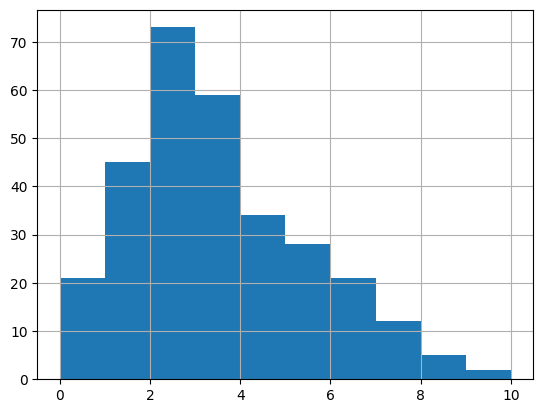

In [23]:
df2["shots"].hist()

In [25]:
df3 = df2.copy(deep=True)

exclude_columns = ['liga', 'match', 'team1']

cols = df1.columns.difference(exclude_columns)

df3[cols] = np.log1p(df3[cols]) 

df3.head()

,match,team1,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,liga
0,2499737,1610,5.037813,2.706855,5.666200,5.019433,5.275129,2.005858,1.609438,7.104144,4.486482,1.386294,England
1,2499737,1624,5.854200,3.588810,5.725948,5.834599,6.586402,2.769153,2.484907,7.861727,4.704170,1.386294,England
2,2499743,1609,6.108722,3.644258,5.757257,6.208147,6.901895,2.593131,1.609438,7.756195,4.765881,1.098612,England
3,2499743,1612,5.577640,3.215682,5.691911,5.327758,6.075478,2.441464,2.079442,7.567346,5.125785,1.791759,England
4,2499754,1612,5.591302,4.283115,6.185154,5.415984,5.710206,2.436548,1.098612,7.448916,5.335975,1.098612,England


In [35]:
# Escaleo de las variables ------------
exclude_columns = ['liga', 'team1', 'match']                                             # Columnas a excluir del escalado

columns_to_scale = df3.columns.difference(exclude_columns)

scaler = StandardScaler()                                                               # Crear un StandardScaler

df3[columns_to_scale] = scaler.fit_transform(df3[columns_to_scale])                     # Seleccionar solo las columnas que queremos escalar

print (df3.shape)

df3.tail()

(300, 13)


,match,team1,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,liga
295,2576302,3161,0.139418,-0.482783,1.512781,-0.086277,-0.048222,-0.326110,0.276859,-0.768619,-1.509317,-0.308934,Italy
296,2576322,3158,1.399956,-0.045899,1.025334,-0.033317,0.708978,-0.149655,0.276859,0.638733,0.862744,-2.341767,Italy
297,2576322,3159,-0.041167,-1.885178,-0.141949,0.130570,0.790066,-0.071061,-2.147885,0.105825,0.621911,-0.308934,Italy
298,2576335,3161,0.712002,0.523953,0.735618,-0.235579,1.116477,-0.018106,0.043301,-0.005198,-0.604540,-0.308934,Italy
299,2576335,3162,-1.133270,-0.149022,-1.587848,-0.521553,-2.899015,-0.370263,-0.226321,-1.350040,-0.480639,0.636280,Italy


In [36]:
df3.to_csv("metrics_2_first6.csv",index=False)

### Rankings

Uso los puntos que obtuvieron en el campeonato para asignar un ranking

In [10]:
wyid2ptos= { 

    "Spain":{
        674:73,675:76,676:93,677:29,678:43,679:79,680:58,682:61,
        683:20,684:60,687:49,691:49,692:49,695:46,696:47,698:55,
        701:51,712:43,714:22,756:51
    },

    "England":{
        1609:63, 1610:70, 1611:81, 1612:75, 1613:44, 1619:36, 
        1623:49, 1624:77, 1625:100, 1627:31, 1628:44, 1631:47, 
        1633:42, 1639:33, 1644:41, 1646:54, 1651:40, 1659:44, 
        1673:37, 10531:33
    },
    "Italy":{
        3157:64, 3158:77, 3159:95, 3161:72, 3162:72, 3163:40, 3164:54, 
        3165:40, 3166:39, 3172:60, 3173:39, 3176:57, 3185:54, 3187:91, 
        3193:41, 3194:25, 3197:35, 3204:38, 3219:21, 3315:43
    },
    "France":{
        3766:78, 3767:93, 3770:52, 3771:77, 3772:55, 3774:58, 
        3775:54, 3776:38, 3777:26, 3779:38, 3780:37, 3782:55, 
        3783:38, 3785:47, 3787:51, 3789:45, 3795:33, 3799:41, 
        3804:48, 19830:80
    },
    "Germany":{
        2443:42, 2444:84, 2445:51, 2446:54, 2447:54.5, 2449:63, 
        2450:31, 2451:33, 2453:36, 2454:47, 2455:39, 2457:43, 
        2460:36, 2462:49, 2463:22, 2481:41, 2482:55, 2975:53 
    }

}

ligaEquipo2rank={ liga:{} for liga in wyid2ptos.keys() }

for liga in wyid2ptos.keys():

    rank=1

    for team, ptos in sorted(wyid2ptos[liga].items(), key=lambda a:a[1], reverse=True):

        ligaEquipo2rank[liga][team]=rank

        rank+=1


json.dump( ligaEquipo2rank, open("league2team2rank.json","w") )